In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


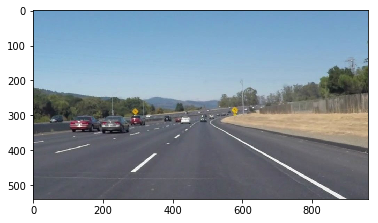

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image2 = np.copy(image)
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

In [3]:
import math
import numpy as np 

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    i = 0
    j = 0
    s = 0
    t = 0
    lm1=0.
    rm1=0.
    lc_x1=0.
    lc_y1=0.
    rc_x1=0.
    rc_y1=0.
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            center = [(x1+x2)/2, (y1+y2)/2]
            if slope > 0 and slope < 0.9:
                rm1=rm1+slope
                rc_x1=(x1+x2)/2 + rc_x1
                rc_y1=(y1+y2)/2 + rc_y1
                if s == 0 :
                    x_first_left = x1
                    y_first_left = y1
                s = s+1
            else: 
                
                lm1=lm1+slope
                lc_x1=(x1+x2)/2 + lc_x1
                lc_y1=(y1+y2)/2 + lc_y1
                if t ==0 :
                    x_first_right = x1
                    y_first_right = y1
                    
                    
                t = t+1
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    rm_avg=rm1/s    
    lm_avg=lm1/t    
    rc_x_avg_new=rc_x1/s
    rc_y_avg_new=rc_y1/s
    lc_x_avg_new=lc_x1/t
    lc_y_avg_new=lc_y1/t    
    y_end = 320
    #for left lines:    
    x_left_end= int(round(lc_x_avg_new + (y_end- lc_y_avg_new)/lm_avg))
    x_left_begin= int(round(lc_x_avg_new - (lc_y_avg_new-540)/lm_avg))   
    lc_x_avg_new_round = int(round(lc_x_avg_new))
    lc_y_avg_new_round = int(round(lc_y_avg_new))      
    #cv2.line(img, (x_left_begin, 540), (x_left_end, y_end), [255, 0, 0], 6)
    ##for right lines:
    x_right_end= int(round(rc_x_avg_new + (y_end- rc_y_avg_new)/rm_avg))
    x_right_begin= int(round(rc_x_avg_new - (rc_y_avg_new-540)/rm_avg))    
    rc_x_avg_new_round = int(round(rc_x_avg_new))
    rc_y_avg_new_round = int(round(rc_y_avg_new))    
    #cv2.line(img, (x_right_begin, 540), (x_right_end, y_end), [255, 0, 0], 6)
    
    
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

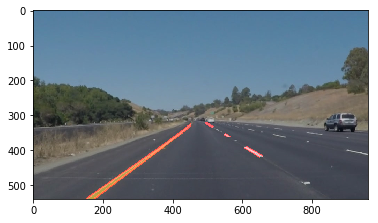

In [4]:
import os
files = os.listdir("test_images/")
for file in files:
    if file[0:6] != "output":
        img = mpimg.imread("test_images/"+ file)
        gray = grayscale(img)
        gray = gaussian_blur(gray, 3)
        edges = canny(gray,50,150)
        imshape = img.shape
        #imshape[1]: width of the image
        #imshape[1]: height of the image
        vertices = np.array([[(.51*imshape[1],imshape[0]*.58,), (.49*imshape[1], imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)    
        target = region_of_interest(edges, vertices)
    
        lines = hough_lines(target, 1, np.pi/180, 35, 5, 2)
    
    
        result = weighted_img(lines, img, α=0.8, β=1.0)
    
        plt.imshow(result, cmap='gray')
        r,g,b = cv2.split(result)
        result = cv2.merge((b,g,r))
        cv2.imwrite("test_images/output_"+file,result) 

In [5]:
import math
import numpy as np 

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    i = 0
    j = 0
    s = 0
    t = 0
    lm1=0.
    rm1=0.
    lc_x1=0.
    lc_y1=0.
    rc_x1=0.
    rc_y1=0.
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            center = [(x1+x2)/2, (y1+y2)/2]
            if slope > 0 and slope < 0.9:
                rm1=rm1+slope
                rc_x1=(x1+x2)/2 + rc_x1
                rc_y1=(y1+y2)/2 + rc_y1
                if s == 0 :
                    x_first_left = x1
                    y_first_left = y1
                s = s+1
            else: 
                
                lm1=lm1+slope
                lc_x1=(x1+x2)/2 + lc_x1
                lc_y1=(y1+y2)/2 + lc_y1
                if t ==0 :
                    x_first_right = x1
                    y_first_right = y1
                    
                    
                t = t+1
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    rm_avg=rm1/s    
    lm_avg=lm1/t    
    rc_x_avg_new=rc_x1/s
    rc_y_avg_new=rc_y1/s
    lc_x_avg_new=lc_x1/t
    lc_y_avg_new=lc_y1/t    
    y_end = 320
    #for left lines:    
    x_left_end= int(round(lc_x_avg_new + (y_end- lc_y_avg_new)/lm_avg))
    x_left_begin= int(round(lc_x_avg_new - (lc_y_avg_new-540)/lm_avg))   
    lc_x_avg_new_round = int(round(lc_x_avg_new))
    lc_y_avg_new_round = int(round(lc_y_avg_new))  
    # Below, we draw left line by conecting two points on the left: the start and the end points. for end point it is 
    #considered y=320. for start point it is considered y = 540 (y is almost always constant, and it is x that is changing)
    cv2.line(img, (x_left_begin, 540), (x_left_end, y_end), [255, 0, 0], 6)   
    ##for right lines:
    x_right_end= int(round(rc_x_avg_new + (y_end- rc_y_avg_new)/rm_avg))
    x_right_begin= int(round(rc_x_avg_new - (rc_y_avg_new-540)/rm_avg))    
    rc_x_avg_new_round = int(round(rc_x_avg_new))
    rc_y_avg_new_round = int(round(rc_y_avg_new)) 
    #Below, we draw right line by conecting two points on the left: the start and the end points. for end point it is 
    #considered y=320. for start point it is considered y = 540 (y is almost always constant, and it is x that is changing)
    cv2.line(img, (x_right_begin, 540), (x_right_end, y_end), [255, 0, 0], 6)
    
    
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    gray = gaussian_blur(gray, 3)
    edges = canny(gray,50,150)
    
    imshape = img.shape
    #imshape[1]: width of the image
    #imshape[1]: height of the image
    vertices = np.array([[(.51*imshape[1],imshape[0]*.58,), (.49*imshape[1], imshape[0]*.58),(0,imshape[0]),(imshape[1],imshape[0])]], dtype=np.int32)    
    target = region_of_interest(edges, vertices)
    
    lines = hough_lines(target, 1, np.pi/180, 35, 5, 2)
    
    
    result = weighted_img(lines, image, α=0.8, β=1.0)

    return result

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 15.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.74 s, sys: 282 ms, total: 3.02 s
Wall time: 14.7 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:44<00:00, 15.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.66 s, sys: 609 ms, total: 9.27 s
Wall time: 45.9 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))